# Abdullah Alhussni - aa10108
## Applied Machine Learning - ENGR-UH 3332 - Project 2
## Instructions: Just restart the kernel and run all cells. Accuracy in task 7 is "good" in 7 out of each 10 runs, due to randomness (in the points but even more in the initial guesses for w and b). If the results aren't nice, rerun the program (preferably by restarting the kernel too), and then once more if it still doesn't show accuracy > 80%.

# 1

In [38]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 500, n_features = 3, n_informative = 3,
                           n_redundant = 0, n_clusters_per_class = 1,
                           flip_y = 0.1,    # adds a small amount of noise
                           class_sep = 1.0, # classes are separable but not too easily
                           random_state = 40)

n = X.shape[0]
N = X.shape[1]

y = 2 * y - 1 # relabeling from 1/0 to +1/-1

# 2

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 3

In [40]:
def loss(w, X, y, b, C):
    n = X.shape[0]
    hinge = 0
    for i in range(n):
        hinge += np.maximum(0, 1 - y[i] * (np.dot(w, X[i, :].T) + b))
    return (np.dot(w, w.T) / 2 + C * hinge / n)

def w_grad(w, b, X, y, C):
    n = X.shape[0]
    hinge_grad = np.zeros(N)
    for i in range(n):
        if(np.maximum(0, 1 - y[i] * (np.dot(w, X[i, :].T) + b)) != 0):
            hinge_grad += C * y[i] * X[i, :]
    return (w - hinge_grad / n)

def b_grad(w, b, X, y, C):
    n = X.shape[0]
    hinge_grad = 0
    for i in range(n):
        if(np.maximum(0, 1 - y[i] * (np.dot(w, X[i, :].T) + b)) != 0):
            hinge_grad -= C * y[i]
    return (- hinge_grad / n)
 
C = np.logspace(-3, 7, num = 41)

# 4

In [41]:
def MBSGD(X_train, y_train, n_batches, n_epochs, eta, w, b, C):
    loss_time = [loss(w, X_train, y_train, b, C)]
    batch_size = len(X_train) // n_batches

    for i in range(n_epochs):
        X_train_batches = []
        y_train_batches = []

        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]

        X_train_batches = [X_train[i * batch_size:(i + 1) * batch_size] for i in range(n_batches)]
        y_train_batches = [y_train[i * batch_size:(i + 1) * batch_size] for i in range(n_batches)]

        # Redefine the last batch to add all the remaining data to it, since data might not be evenly divisible by n_batches
        # For instance: 500 to 10 batches won't, but 500 to 12 batches for instance will have 41 for batches 1-11 and 49 for batch 12

        if len(X_train) % n_batches != 0:
            X_train_batches[-1] = X_train[(n_batches - 1) * batch_size:]
            y_train_batches[-1] = y_train[(n_batches - 1) * batch_size:]

        for j in range(n_batches):
            dw = eta * w_grad(w, b, X_train_batches[j], y_train_batches[j], C)
            db = eta * b_grad(w, b, X_train_batches[j], y_train_batches[j], C)
            w = w - dw
            b = b - db

        loss_time = np.append(loss_time, loss(w, X, y, b, C))

    return [w, b, loss_time]

w_init = np.random.rand(N)
b_init = np.random.rand()

n_batches = 10
n_epochs = 40 # through some trial and error, 40 seems like the best figure
eta = 0.01

loss_time = np.zeros((n_epochs + 1, C.size))

w_optimal_C = np.zeros((C.size, N))
b_optimal_C = np.zeros(C.size)

for i in range(len(C)):
    [w_optimal_C[i, :], b_optimal_C[i], loss_time[:, i]] = MBSGD(X_train, y_train, n_batches, n_epochs, eta, w_init, b_init, C[i])

# 5

In [42]:
print(f"An example of optimal weights (w): {w_optimal_C[10, :]}")
print(f"An example of optimal bias (b): {b_optimal_C[10]}")

An example of optimal weights (w): [-0.2128009  -0.20385409 -0.05417422]
An example of optimal bias (b): 0.27151718248268336


Instead of printing w and b for all C values, I printed one only. In the following two sections, we will show why we picked the optimal weights and bias (C is usually around 0.316), but they are the ones that maximize the accuracy (with respect to C values).

# 6

In [43]:
def accuracy_for_C(X, y, w_optimal, b_optimal, C):
    y_pred = np.zeros((y.size, 1))

    for i in range(len(y)):
        y_pred[i] = np.sign(np.dot(X[i], w_optimal.T) + b_optimal)
    
    accuracy = accuracy_score(y, y_pred)
    return accuracy

After some experiments, training accuracy is the same as test accuracy, no need to do both.

# 7

In [44]:
accuracy = np.zeros(len(C))

for i in range(len(C)):
    accuracy[i] = accuracy_for_C(X_train, y_train, w_optimal_C[i, :], b_optimal_C[i], C[i])

max_accuracy = np.max(accuracy)
i_optimal = np.argmax(accuracy)
C_optimal = C[i_optimal]
w_optimal = w_optimal_C[i_optimal, :]
b_optimal = b_optimal_C[i_optimal]

print(f"Accuracy of training data for optimal C: {max_accuracy * 100:.2f}%")
print(f"Optimal C: {C_optimal}")
print(f"Optimal weights (w): {w_optimal}")
print(f"Optimal bias (b): {b_optimal}")

Accuracy of training data for optimal C: 84.75%
Optimal C: 0.31622776601683794
Optimal weights (w): [-0.2128009  -0.20385409 -0.05417422]
Optimal bias (b): 0.27151718248268336


# 8

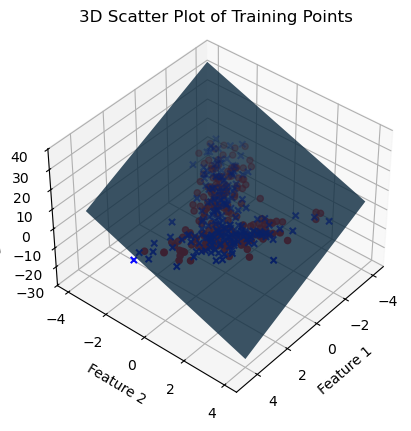

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

# Plot the 3D points (scatter plot)

Xp = []
Yp = []
Zp = []
Xm = []
Ym = []
Zm = []

for i in range(X_train.shape[0]):
    if(y[i] == 1):
        Xp = np.append(Xp, X_train[i, 0])
        Yp = np.append(Yp, X_train[i, 1])
        Zp = np.append(Zp, X_train[i, 2])
    elif(y[i] == -1):
        Xm = np.append(Xm, X_train[i, 0])
        Ym = np.append(Ym, X_train[i, 1])
        Zm = np.append(Zm, X_train[i, 2])

ax.scatter(Xp, Yp, Zp, c = 'r', marker = 'o')
ax.scatter(Xm, Ym, Zm, c = 'b', marker = 'x')

xp = np.linspace(-4, 4, 10)
yp = np.linspace(-4, 4, 10)
Xpp, Ypp = np.meshgrid(xp, yp)

# The plane equation
Zpp = (- Xpp * w_optimal[0] - Ypp * w_optimal[1] - b_optimal) / w_optimal[2]

ax.plot_surface(Xpp, Ypp, Zpp, alpha = 0.8, rstride = 100, cstride = 100)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

ax.set_title('3D Scatter Plot of Training Points')

azim = 40 # np.degrees(np.arctan2(w[1], w[0])) - 90
elev = 40 # np.degrees(np.arctan2(w[2], np.sqrt(w[0] ** 2 + w[1] ** 2))) + 90

ax.view_init(elev = elev, azim = azim)
plt.show()

# 9

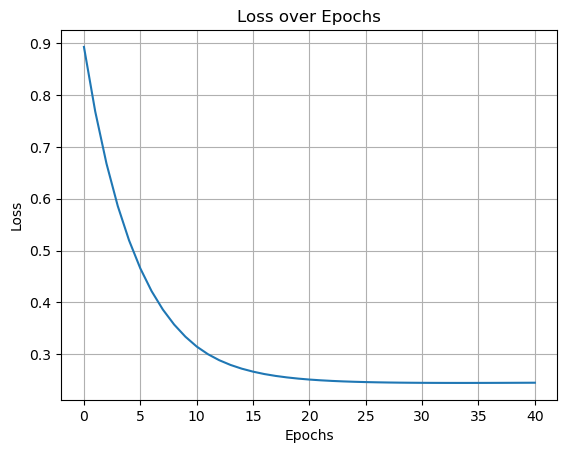

In [46]:
plt.plot(range(n_epochs + 1), loss_time[:, i_optimal])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()